In [1]:
# %%
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# %%
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_size = int(0.9 * len(train_dataset))
val_size   = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = 10


In [3]:
# %%
class SimpleCNN(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.drop1 = nn.Dropout2d(dropout_p)
        self.drop2 = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = self.drop1(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)


In [4]:
# %%
class BayesianLinear(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.weight_mu = nn.Parameter(torch.randn(out_f, in_f) * 0.05)
        self.weight_logvar = nn.Parameter(torch.full((out_f, in_f), -5.))
        self.bias_mu = nn.Parameter(torch.zeros(out_f))
        self.bias_logvar = nn.Parameter(torch.full((out_f,), -5.))

    def forward(self, x):
        w = self.weight_mu + torch.exp(0.5*self.weight_logvar) * torch.randn_like(self.weight_logvar)
        b = self.bias_mu   + torch.exp(0.5*self.bias_logvar) * torch.randn_like(self.bias_logvar)
        return F.linear(x, w, b)

    def kl(self):
        return 0.5 * (
            torch.sum(self.weight_mu**2 + torch.exp(self.weight_logvar) - 1 - self.weight_logvar) +
            torch.sum(self.bias_mu**2   + torch.exp(self.bias_logvar)  - 1 - self.bias_logvar)
        )

class BayesMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = BayesianLinear(784, 400)
        self.fc2 = BayesianLinear(400, 10)

    def forward(self, x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def kl(self):
        return self.fc1.kl() + self.fc2.kl()


In [5]:
# %%
class BayesianLinear(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.weight_mu = nn.Parameter(torch.randn(out_f, in_f) * 0.05)
        self.weight_logvar = nn.Parameter(torch.full((out_f, in_f), -5.))
        self.bias_mu = nn.Parameter(torch.zeros(out_f))
        self.bias_logvar = nn.Parameter(torch.full((out_f,), -5.))

    def forward(self, x):
        w = self.weight_mu + torch.exp(0.5*self.weight_logvar) * torch.randn_like(self.weight_logvar)
        b = self.bias_mu   + torch.exp(0.5*self.bias_logvar) * torch.randn_like(self.bias_logvar)
        return F.linear(x, w, b)

    def kl(self):
        return 0.5 * (
            torch.sum(self.weight_mu**2 + torch.exp(self.weight_logvar) - 1 - self.weight_logvar) +
            torch.sum(self.bias_mu**2   + torch.exp(self.bias_logvar)  - 1 - self.bias_logvar)
        )

class BayesMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = BayesianLinear(784, 400)
        self.fc2 = BayesianLinear(400, 10)

    def forward(self, x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def kl(self):
        return self.fc1.kl() + self.fc2.kl()


In [6]:
# %%
class PBPLinear(nn.Module):
    def __init__(self, in_f, out_f, init_var=1e-3):
        super().__init__()
        self.mu_w = nn.Parameter(torch.randn(out_f, in_f) * 0.05)
        self.logvar_w = nn.Parameter(torch.full((out_f, in_f), np.log(init_var)))

        self.mu_b = nn.Parameter(torch.zeros(out_f))
        self.logvar_b = nn.Parameter(torch.full((out_f,), np.log(init_var)))

    def forward(self, x):
        w = self.mu_w + torch.exp(0.5*self.logvar_w) * torch.randn_like(self.mu_w)
        b = self.mu_b + torch.exp(0.5*self.logvar_b) * torch.randn_like(self.mu_b)
        return F.linear(x, w, b)

    def kl(self):
        return 0.5 * (
            torch.sum(self.mu_w**2 + torch.exp(self.logvar_w) - 1 - self.logvar_w) +
            torch.sum(self.mu_b**2 + torch.exp(self.logvar_b) - 1 - self.logvar_b)
        )

class PBPNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = PBPLinear(784, 400)
        self.fc2 = PBPLinear(400, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def kl(self):
        return self.fc1.kl() + self.fc2.kl()


In [7]:
# %%
def train_epoch(model, loader, optimizer, loss_fn, kl_weight=0):
    model.train()
    total_loss=0; correct=0; N=0

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = loss_fn(logits, y)

        loss = ce_loss
        if kl_weight > 0:
            loss += kl_weight * model.kl() / len(train_ds)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()*x.size(0)
        correct    += (logits.argmax(1)==y).sum().item()
        N += x.size(0)

    return total_loss/N, correct/N


@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval()
    total_loss=0; correct=0; N=0

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)

        total_loss += loss.item()*x.size(0)
        correct    += (logits.argmax(1)==y).sum().item()
        N += x.size(0)

    return total_loss/N, correct/N


In [8]:
# %%
epochs = 3
loss_fn = nn.CrossEntropyLoss()

# Standard
standard_model = SimpleCNN().to(device)
opt_std = torch.optim.Adam(standard_model.parameters(), lr=1e-3)

# MC Dropout
mc_model = SimpleCNN().to(device)
opt_mc = torch.optim.Adam(mc_model.parameters(), lr=1e-3)

# VI
vi_model = BayesMLP().to(device)
opt_vi = torch.optim.Adam(vi_model.parameters(), lr=1e-3)

# PBP
pbp_model = PBPNet().to(device)
opt_pbp = torch.optim.Adam(pbp_model.parameters(), lr=1e-3)

print("Training Standard NN...")
for e in range(epochs):
    t,a = train_epoch(standard_model, train_loader, opt_std, loss_fn)
    v,va = eval_epoch(standard_model, val_loader, loss_fn)
    print(e, t,a, v,va)

print("\nTraining MC Dropout...")
for e in range(epochs):
    t,a = train_epoch(mc_model, train_loader, opt_mc, loss_fn)
    v,va = eval_epoch(mc_model, val_loader, loss_fn)
    print(e, t,a, v,va)

print("\nTraining VI (BBB)...")
for e in range(epochs):
    t,a = train_epoch(vi_model, train_loader, opt_vi, loss_fn, kl_weight=1.0)
    v,va = eval_epoch(vi_model, val_loader, loss_fn)
    print(e, t,a, v,va)

print("\nTraining PBP...")
for e in range(epochs):
    t,a = train_epoch(pbp_model, train_loader, opt_pbp, loss_fn, kl_weight=1.0)
    v,va = eval_epoch(pbp_model, val_loader, loss_fn)
    print(e, t,a, v,va)


Training Standard NN...
0 0.26524541557718206 0.9186666666666666 0.06668347832063834 0.9801666666666666
1 0.11078610659087146 0.9674259259259259 0.05102156442155441 0.9831666666666666
2 0.08787201103457698 0.9736296296296296 0.04189949753880501 0.987

Training MC Dropout...
0 0.28729117436320695 0.9132777777777777 0.07713944687942664 0.9761666666666666
1 0.11585352771591258 0.9668518518518519 0.05218874606738488 0.9838333333333333
2 0.08988708319818532 0.9733148148148149 0.053044533664981526 0.9838333333333333

Training VI (BBB)...
0 12.989132298222295 0.6755555555555556 0.5675502080917358 0.8296666666666667
1 12.13015668685348 0.8685 0.3884563814004262 0.8838333333333334
2 11.872021347045898 0.905425925925926 0.3056376850605011 0.9121666666666667

Training PBP...
0 17.562555122092917 0.8853518518518518 0.20343051568667095 0.9373333333333334
1 16.791096904048214 0.9524814814814815 0.144606224099795 0.9546666666666667
2 16.0961488410102 0.9657407407407408 0.12228529220819473 0.961666666

In [9]:
# %%
@torch.no_grad()
def predict_standard(model, loader):
    model.eval()
    probs=[]; labels=[]
    for x,y in loader:
        x=x.to(device)
        p = F.softmax(model(x),1).cpu().numpy()
        probs.append(p)
        labels.append(y.numpy())
    probs=np.concatenate(probs)
    labels=np.concatenate(labels)
    preds = probs.argmax(1)
    conf  = probs.max(1)
    return probs, preds, conf, labels

@torch.no_grad()
@torch.no_grad()
def predict_mc(model, loader, S=20):
    model.train()
    all_samples=[]
    labels=None

    for _ in range(S):
        probs=[]; labs=[]
        for x,y in loader:
            x = x.to(device)
            p = F.softmax(model(x),1).cpu().numpy()
            probs.append(p); labs.append(y.numpy())
        all_samples.append(np.concatenate(probs))
        labels = np.concatenate(labs)

    all_samples = np.stack(all_samples)      # (S, N, C)
    mean_probs = all_samples.mean(axis=0)    # (N, C)

    preds  = mean_probs.argmax(1)
    conf   = mean_probs.max(1)
    uncert = -np.sum(mean_probs*np.log(mean_probs+1e-12),1)

    return all_samples, mean_probs, preds, conf, uncert, labels


@torch.no_grad()
@torch.no_grad()
def predict_vi(model, loader, S=20):
    model.eval()
    all_samples=[]
    labels=None

    for _ in range(S):
        probs=[]; labs=[]
        for x,y in loader:
            x=x.to(device)
            p = F.softmax(model(x),1).cpu().numpy()
            probs.append(p); labs.append(y.numpy())
        all_samples.append(np.concatenate(probs))
        labels=np.concatenate(labs)

    all_samples = np.stack(all_samples)
    mean_probs = all_samples.mean(axis=0)

    preds  = mean_probs.argmax(1)
    conf   = mean_probs.max(1)
    uncert = -np.sum(mean_probs*np.log(mean_probs+1e-12),1)

    return all_samples, mean_probs, preds, conf, uncert, labels


@torch.no_grad()
@torch.no_grad()
def predict_pbp(model, loader, S=20):
    model.eval()
    all_samples=[]
    labels=None

    for _ in range(S):
        probs=[]; labs=[]
        for x,y in loader:
            x=x.to(device)
            p = F.softmax(model(x),1).cpu().numpy()
            probs.append(p); labs.append(y.numpy())
        all_samples.append(np.concatenate(probs))
        labels=np.concatenate(labs)

    all_samples = np.stack(all_samples)
    mean_probs = all_samples.mean(axis=0)

    preds  = mean_probs.argmax(1)
    conf   = mean_probs.max(1)
    uncert = -np.sum(mean_probs*np.log(mean_probs+1e-12),1)

    return all_samples, mean_probs, preds, conf, uncert, labels



In [11]:
# %%
std_probs, std_preds, std_conf, y_true = predict_standard(standard_model, test_loader)
mc_samples, mc_probs, mc_preds, mc_conf, mc_uncert, y_true = predict_mc(mc_model, test_loader)
vi_samples, vi_probs, vi_preds, vi_conf, vi_uncert, y_true = predict_vi(vi_model, test_loader)
pbp_samples, pbp_probs, pbp_preds, pbp_conf, pbp_uncert, y_true = predict_pbp(pbp_model, test_loader)


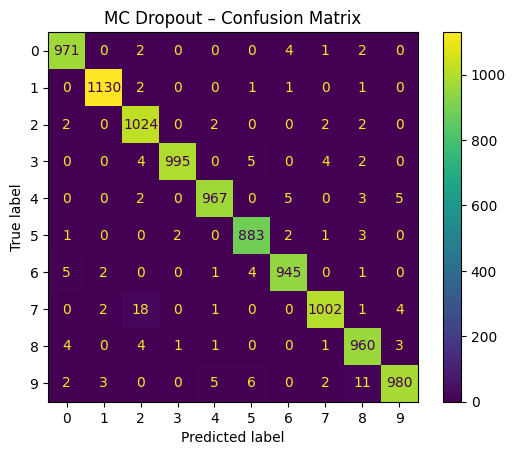

In [12]:
# %%
cm = confusion_matrix(y_true, mc_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("MC Dropout – Confusion Matrix")
plt.show()


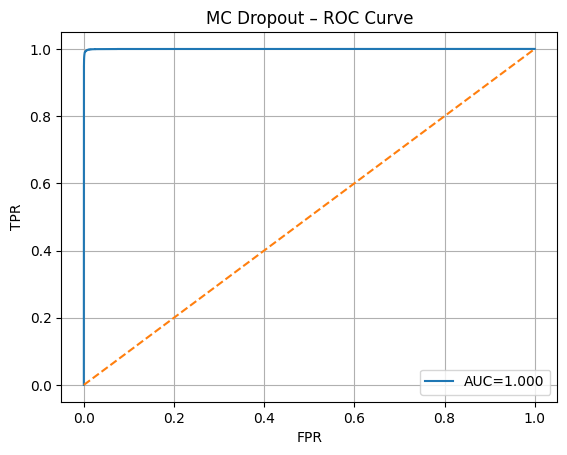

In [13]:
# %%
y_bin = label_binarize(y_true, classes=np.arange(num_classes))
fpr, tpr, _ = roc_curve(y_bin.ravel(), mc_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("MC Dropout – ROC Curve")
plt.legend()
plt.grid()
plt.show()


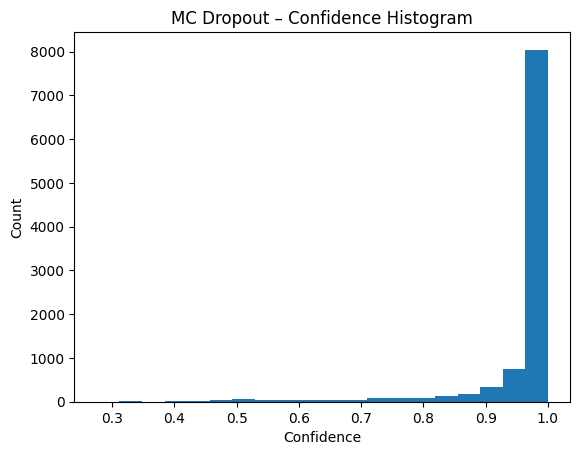

In [14]:
# %%
plt.hist(mc_conf, bins=20)
plt.title("MC Dropout – Confidence Histogram")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()


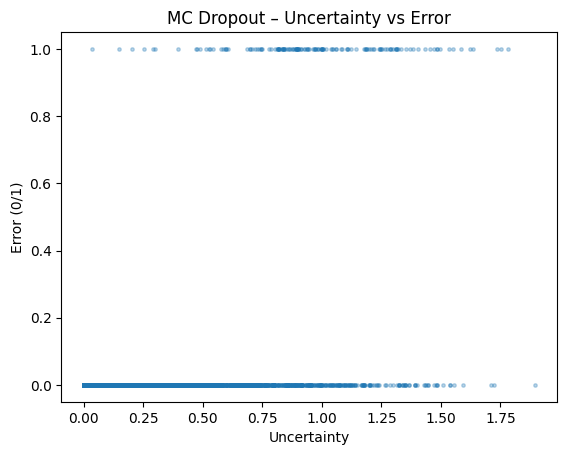

In [15]:
# %%
mc_errors = (mc_preds != y_true).astype(int)

plt.scatter(mc_uncert, mc_errors, s=6, alpha=0.3)
plt.xlabel("Uncertainty")
plt.ylabel("Error (0/1)")
plt.title("MC Dropout – Uncertainty vs Error")
plt.show()


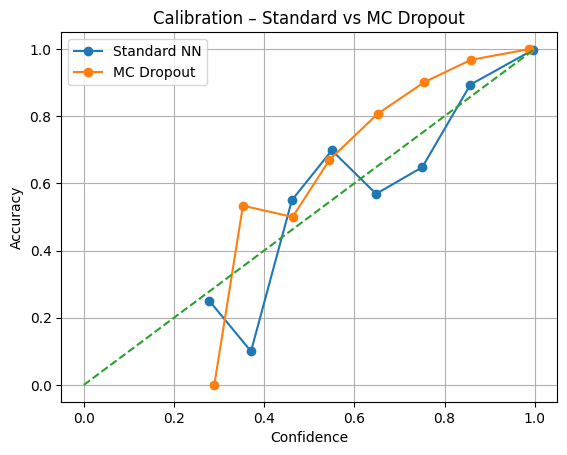

In [16]:
# %%
std_corr = (std_preds == y_true).astype(int)
mc_corr  = (mc_preds == y_true).astype(int)

pt_s, pp_s = calibration_curve(std_corr, std_conf, n_bins=10)
pt_m, pp_m = calibration_curve(mc_corr,  mc_conf,  n_bins=10)

plt.plot(pp_s, pt_s, marker='o', label="Standard NN")
plt.plot(pp_m, pt_m, marker='o', label="MC Dropout")
plt.plot([0,1],[0,1],'--')
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title("Calibration – Standard vs MC Dropout")
plt.legend()
plt.grid()
plt.show()


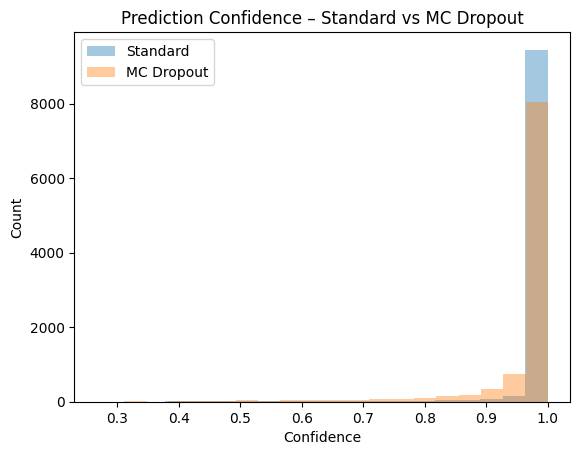

In [17]:
# %%
plt.hist(std_conf, bins=20, alpha=0.4, label="Standard")
plt.hist(mc_conf,  bins=20, alpha=0.4, label="MC Dropout")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.title("Prediction Confidence – Standard vs MC Dropout")
plt.legend()
plt.show()


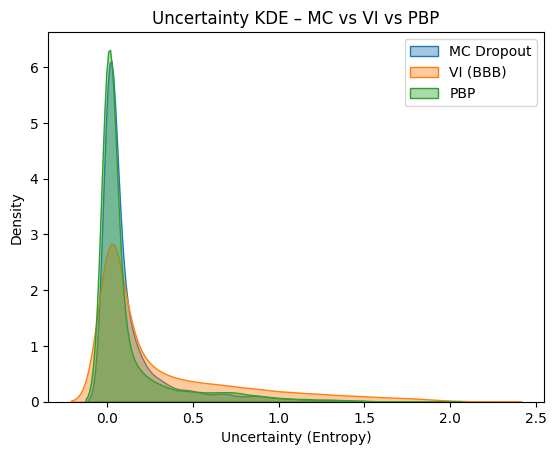

In [18]:
# %%
sns.kdeplot(mc_uncert, fill=True, alpha=0.4, label="MC Dropout")
sns.kdeplot(vi_uncert, fill=True, alpha=0.4, label="VI (BBB)")
sns.kdeplot(pbp_uncert, fill=True, alpha=0.4, label="PBP")
plt.xlabel("Uncertainty (Entropy)")
plt.ylabel("Density")
plt.title("Uncertainty KDE – MC vs VI vs PBP")
plt.legend()
plt.show()


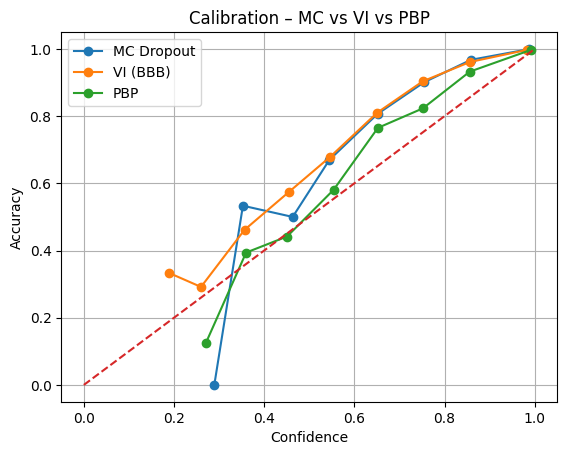

In [19]:
# %%
vi_corr = (vi_preds == y_true).astype(int)
pbp_corr = (pbp_preds == y_true).astype(int)

pt_vi, pp_vi = calibration_curve(vi_corr,  vi_conf,  n_bins=10)
pt_pb, pp_pb = calibration_curve(pbp_corr, pbp_conf, n_bins=10)

plt.plot(pp_m,  pt_m,  marker='o', label="MC Dropout")
plt.plot(pp_vi, pt_vi, marker='o', label="VI (BBB)")
plt.plot(pp_pb, pt_pb, marker='o', label="PBP")
plt.plot([0,1],[0,1],'--')

plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title("Calibration – MC vs VI vs PBP")
plt.legend()
plt.grid()
plt.show()


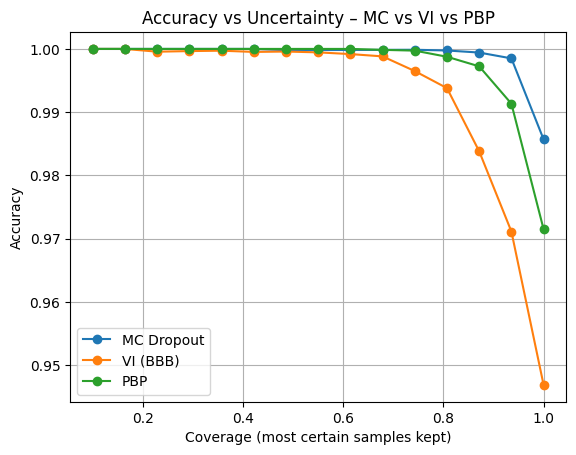

In [20]:
# %%
def accuracy_vs_uncert(errors, uncert):
    idx = np.argsort(uncert)
    errs = errors[idx]
    cov = np.linspace(0.1,1.0,15)
    acc=[]
    for c in cov:
        k=int(c*len(errs))
        acc.append(1-errs[:k].mean())
    return cov,acc

errors_vi  = (vi_preds != y_true).astype(int)
errors_pbp = (pbp_preds != y_true).astype(int)

cov_mc, acc_mc     = accuracy_vs_uncert(mc_errors, mc_uncert)
cov_vi, acc_vi     = accuracy_vs_uncert(errors_vi, vi_uncert)
cov_pbp, acc_pbp   = accuracy_vs_uncert(errors_pbp, pbp_uncert)

plt.plot(cov_mc,  acc_mc,  marker='o', label="MC Dropout")
plt.plot(cov_vi,  acc_vi,  marker='o', label="VI (BBB)")
plt.plot(cov_pbp, acc_pbp, marker='o', label="PBP")

plt.xlabel("Coverage (most certain samples kept)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Uncertainty – MC vs VI vs PBP")
plt.legend()
plt.grid()
plt.show()


In [21]:
def compute_rmse_and_std(prob_list, labels):
    """
    prob_list: list of arrays [(N,C), (N,C), ...] or a single array (N,C)
    """
    if isinstance(prob_list, np.ndarray):  # deterministic model
        prob_list = [prob_list]

    onehot = np.eye(10)[labels]

    rmses = [np.sqrt(((p - onehot)**2).mean()) for p in prob_list]
    return np.mean(rmses), np.std(rmses)


def compute_ll_and_std(prob_list, labels):
    if isinstance(prob_list, np.ndarray):
        prob_list = [prob_list]

    eps = 1e-12
    lls = [np.mean(np.log(p[np.arange(len(labels)), labels] + eps))
           for p in prob_list]

    return np.mean(lls), np.std(lls)


In [26]:
std_prob_list = [std_probs]
mc_prob_list = [mc_samples[i] for i in range(mc_samples.shape[0])]
vi_prob_list = [vi_samples[i] for i in range(vi_samples.shape[0])]
pbp_prob_list = [pbp_samples[i] for i in range(pbp_samples.shape[0])]

In [30]:
rmse_std_mean, rmse_std_std = compute_rmse_and_std(std_prob_list, y_true)
ll_std_mean,  ll_std_std    = compute_ll_and_std(std_prob_list, y_true)

rmse_mc_mean,  rmse_mc_std  = compute_rmse_and_std(mc_prob_list, y_true)
ll_mc_mean,     ll_mc_std   = compute_ll_and_std(mc_prob_list, y_true)

rmse_vi_mean,  rmse_vi_std  = compute_rmse_and_std(vi_prob_list, y_true)
ll_vi_mean,     ll_vi_std   = compute_ll_and_std(vi_prob_list, y_true)

rmse_pbp_mean, rmse_pbp_std = compute_rmse_and_std(pbp_prob_list, y_true)
ll_pbp_mean,    ll_pbp_std  = compute_ll_and_std(pbp_prob_list, y_true)


In [31]:
import pandas as pd

df = pd.DataFrame({
    "Model": ["Standard NN", "MC Dropout", "VI (BBB)", "PBP"],

    "RMSE Mean": [rmse_std_mean, rmse_mc_mean, rmse_vi_mean, rmse_pbp_mean],
    "RMSE Std":  [rmse_std_std,  rmse_mc_std,  rmse_vi_std,  rmse_pbp_std],

    "LL Mean":   [ll_std_mean, ll_mc_mean, ll_vi_mean, ll_pbp_mean],
    "LL Std":    [ll_std_std,  ll_mc_std,  ll_vi_std,  ll_pbp_std],
})

df


,Model,RMSE Mean,RMSE Std,LL Mean,LL Std
0,Standard NN,0.041837,0.000000,-0.035284,0.000000
1,MC Dropout,0.064784,0.001389,-0.091993,0.003641
2,VI (BBB),0.111833,0.001189,-0.278344,0.005920
3,PBP,0.073098,0.000828,-0.113335,0.002382


In [32]:
from sklearn.metrics import classification_report, accuracy_score

def print_classification_metrics(model_name, preds, labels):
    print(f"\n--- {model_name} Classification Metrics ---")
    print("Exact Match Accuracy:", accuracy_score(labels, preds))
    print("\nClassification Report:")
    print(classification_report(labels, preds))


In [33]:
print_classification_metrics("Standard NN", std_preds, y_true)



--- Standard NN Classification Metrics ---
Exact Match Accuracy: 0.9881

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [34]:
print_classification_metrics("MC Dropout", mc_preds, y_true)



--- MC Dropout Classification Metrics ---
Exact Match Accuracy: 0.9857

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.97      0.99      0.98      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [35]:
print_classification_metrics("VI (BBB)", vi_preds, y_true)



--- VI (BBB) Classification Metrics ---
Exact Match Accuracy: 0.9469

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.96      0.99      0.98      1135
           2       0.97      0.93      0.95      1032
           3       0.93      0.95      0.94      1010
           4       0.95      0.93      0.94       982
           5       0.95      0.92      0.94       892
           6       0.95      0.97      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.93      0.92      0.93       974
           9       0.92      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [36]:
print_classification_metrics("PBP", pbp_preds, y_true)



--- PBP Classification Metrics ---
Exact Match Accuracy: 0.9715

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.94      0.99      0.96       892
           6       0.99      0.96      0.97       958
           7       0.97      0.98      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

